# Predict students' graduation rate

dataset 
- [from @ roycekimmons.com](http://roycekimmons.com/tools/generated_data/graduation_rate)

> This is a fictional dataset and should only be used for data science training purposes.
> 
> This data set includes graduation rates from a four-year college with a variety of student factors.

The key questions we want to address:

> 1. How effective are entrance requirements at predicting gpa and graduation rate?
> 1. What would be the best way to improve graduation rates?

> All data sets are generated on-the-fly. So, you can increase your n by downloading a data set multiple times and combining the files. (n=1000) per large sample download

Based on the above statement, I have downloaded 5x times and combined them into one csv file so that we can work with a larger sample size of 5000 observations, instead of just 1000 observations.

Target is `'graduate_in_5years'` and column named simply as `'target'`
- feature-engineered from 'years_to_graduate' as 
  - 0: 'Yes' ie 'years_to_graduate' < 6
  - 1: 'No' ie 'years_to_graduate' > 5 
- was set to 4 years initially until EDA reveals median is 5.


In [26]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout

# Configure the logging library.
logging.basicConfig(filename='randomizedcv_tuning.log', level=logging.INFO)

# Set the path to the current file 
current_file_path = Path().resolve()
print(f'{current_file_path = } ')

# Set the path to the data folder
data_folder_path = current_file_path / 'data'
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from src.config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


## Import packages

In [27]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import loguniform
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [28]:
# not supported for HistGradientBoostingClassifier/ CatBoostClassifier
# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

import catboost
from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, confusion_matrix, classification_report


In [29]:
import sklearn
sklearn.__version__

'1.3.1'

## Overview

> do we want 
> - 2 splits for train, test or 
> - 3 splits for train, val and test?
>
> reminder: 
> - not yet stratify
> - not scaled
> - use cross-validation 
> - save final df to file as processed_df.csv?

In this notebook, we're finally going to address the above questions. We're using 
- KFolds to cross-validate our data splitting,
- using just 3 features that were shown as the most important features via EDA
- scale our data, treat outliers ~~using Pipelines~~,
- perform hyperparameters tuning on the 2 classifiers with highest `'val auc'` scores,
- finally, the final chosen "best model" would be identified, and 
- creating scripts out of our POC code would commenced, and that would allow
- save our model to a `.pkl` file for us to deploy model to a web servic.e


## Hyperparameters Tuning

### Putting it all together

Based on findings from baseline scoring, we're gonna limit our GridSearch and hyperparameters tuning to just these 2 classifiers.

Perform data preprocessing and use pipelines to perform hyperparameter tuning to a couple of the models from previous top 2 performers:

- HistGradientBoostingClassifier()
- CatBoostClassifier()


In [30]:
# declare the 3 features we're using to train the model
features = ['parental_income', 'sat_total_score', 'college_gpa'] 
# graduate_in_5years simply labeled as 'target'
target_name = 'target'

In [78]:
# Data ingestion
def rebuild_df(features=None):
    print(f'{TARGET_NAME = }')
    data = CSVDataLoader().load('data/graduation_rate.csv')
    print(f'{features = }')
    print()
    print("- Preprocessor()...")
    data = Preprocessor().ColumnsSymbolReplacer(data)
    # display(data.iloc[11:12])
    data = Preprocessor().SymbolReplacer(data, 'parental_level_of_education')
    # display(data.head(2))
    data = Preprocessor().ColumnsDropper(data, TO_DROP)
    # display(data.head(2))
    data = Preprocessor().DataScaler(data)
    print()
    print("- FeatureBuilder()...")
    data = FeatureBuilder().TargetEncoder(data)
    print("  -- Set COLS_CATEGORICAL astype(category)...")
    data[COLS_CATEGORICAL] = data[COLS_CATEGORICAL].astype('category')
    print()
    print("- Prepare DFs...")
    print("  -- Split TARGET_NAME for y...")
    target = data[TARGET_NAME]
    print("  -- Dropping TARGET_NAME...")
    data = data.drop(columns=TARGET_NAME)
    
    if features:
        data = data[features] 
          
    df_full_train, df_test, y_full_train, y_test = train_test_split(data, target, test_size=0.2, random_state=11)
    
    # reset indices back to begin from 0
    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_full_train = y_full_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return df_full_train, df_test, y_full_train, y_test

In [79]:
df_full_train, df_test, y_full_train, y_test = rebuild_df(features)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11)
df_full_train.head()

TARGET_NAME = 'target'
Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 243.91it/s]

Finished processing the CSV file.
df.shape = (5000, 7)
features = ['parental_income', 'sat_total_score', 'college_gpa']

- Preprocessor()...
  -- Replacing symbols in column names...


,act_composite_score,sat_total_score,parental_level_of_education,parental_income,high_school_gpa,college_gpa,years_to_graduate
11,29,2015,bachelor's degree,76369,3.9,3.4,6


  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...

- FeatureBuilder()...
  -- Creating 'target' column...
  -- Set COLS_CATEGORICAL astype(category)...

- Prepare DFs...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...


,parental_income,sat_total_score,college_gpa
0,-0.165044,0.581050,0.600000
1,-1.011711,0.235160,0.266667
2,-1.570150,0.333333,0.400000
3,-0.680588,0.643836,0.400000
4,-0.856499,0.743151,0.600000


### Hyperparams Tuning on HistGradientBoostingClassifier

#### setup

[source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_randomized_search.html) for `loguniform_int` code snippet

In [33]:
# initialize
scores = []
fold = 0

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

# AUC is not a defined scoring metric for RandomizedSearchCV
scoring = {
    "AUC": make_scorer(roc_auc_score), 
    "Accuracy": make_scorer(accuracy_score), 
    "F1": make_scorer(f1_score),
    "Precision": make_scorer(precision_score), 
    "Recall": make_scorer(recall_score)}

# custom_loss=['Accuracy', 'AUC:hints=skip_train~false', 'F1','Precision', 'Recall']

In [34]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

hist_param_grid = {
    # 'classifier__loss': 'log_loss',                        # defaults, same as catboost's loss_function
    # 'classifier__categorical_features': COLS_CATEGORICAL,  # defaults, same as catboost's cat_features
    'learning_rate': loguniform(0.001, 10.0),    # defaults=0.1, 1=no shrinkage
    'max_iter': loguniform_int(10, 1000),         # defaults=100; max num iterations/trees
    'max_depth': loguniform_int(2, 12),          # defaults=None; max depth of each tree
    'max_leaf_nodes': loguniform_int(2, 256),    # defaults=31;max num of leaves
    'min_samples_leaf': loguniform_int(1, 100),  # defaults=20; min num of samples per leaf
    'early_stopping': ['auto', True],       # defaults='auto'; enabled for sample-size > 10000, else enabled when True
    'class_weight': WEIGHTS
}

# Create the model
model = HistGradientBoostingClassifier(
        # verbose=2, 
        # scoring='roc_auc', 
        warm_start=True,            # defaults=False
        random_state=42             # defaults=None                          
    )

In [35]:
# Create a RandomizedSearchCV object
rnd_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=hist_param_grid, 
    cv=kfold, 
    # n_iter=10,                     # defaults
    # random_state=None,             # also has this here, or use in Classifier()           
    scoring=scoring,                 # to replace defaults 'loss'
    refit="AUC",                     # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)


#### train

In [36]:
all_DFs = [df_full_train, df_train, df_val, df_test]
all_Ys = [y_full_train, y_train, y_val, y_test]
for df in all_DFs:
    print(f'{df.shape = }') 
print()
for y in all_Ys:
    print(f'{y.shape = }')  

df.shape = (4000, 3)
df.shape = (3000, 3)
df.shape = (1000, 3)
df.shape = (1000, 3)

y.shape = (4000,)
y.shape = (3000,)
y.shape = (1000,)
y.shape = (1000,)


In [37]:
%%capture output   
# Log the output of each step of the tuning process.
logging.info('Starting HistGradientBoostingClassifier hyperparam tuning...')

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train.iloc[train_idx].values
    y_val = y_full_train.iloc[val_idx].values
    
    logging.info(f'-- in rnd_search.fit(); kfold: {fold} --')
    fold = fold + 1

    logging.info('Fitting RandomizedSearchCV model...')
    with open('randomizedcv_tuning.log', 'a') as f:
        with redirect_stdout(f):
            # Train the model on the train data
            rnd_search.fit(df_train, y_train)
    
logging.info('RandomizedSearchCV fit completed')    
# GridSearchCV took approx 45mins on my machine! 
# RandomizedSearchCV took approx 15s on my machine! 

#### predict

In [38]:
# Make predictions on the validate data
y_pred_train = rnd_search.predict(df_train)
y_pred_val = rnd_search.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier val scores appended --')

# Log the results of the tuning process.
logging.info('Finished HistGradientBoostingClassifier hyperparam tuning. The best hyperparameters are: {}'.format(rnd_search.best_params_))

In [39]:
pprint(f"The best set of parameters is: {rnd_search.best_params_}")
print()
print(f"train auc: {roc_auc_score(y_train, y_pred_train)}")
print(f"val auc: {roc_auc_score(y_val, y_pred_val)}")


("The best set of parameters is: {'class_weight': 'balanced', "
 "'early_stopping': 'auto', 'learning_rate': 0.007471874727782927, "
 "'max_depth': 3, 'max_iter': 189, 'max_leaf_nodes': 30, 'min_samples_leaf': "
 '5}')

train auc: 0.6487844072663659
val auc: 0.6249192764198072


#### evaluate



In [ ]:
# [source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_parallel_plot.html) for `shorten_param` code snippet

def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name

# [source](https://stackoverflow.com/a/73766566) for `clean_key(key)` code snippet
pattern_list = ['param_', 'split']
def clean_key(key):
    for pattern in pattern_list:
        key = key.replace(pattern, "")
    return key
{clean_key(k) :  v for k, v in x.items()}

In [ ]:
cv_results = rnd_search.cv_results_

In [48]:
rnd_search.cv_results_

{'mean_fit_time': array([0.01259899, 0.51559954, 0.34870534, 0.01499858, 0.1372014 ,
        0.02202077, 0.18357201, 0.42805748, 0.15679927, 0.22080054]),
 'std_fit_time': array([0.00135627, 0.03114271, 0.02480657, 0.00189527, 0.06249653,
        0.00199066, 0.01112641, 0.02904998, 0.03414295, 0.01561274]),
 'mean_score_time': array([0.00760045, 0.03219986, 0.02777958, 0.00739908, 0.01540022,
        0.00797887, 0.02160039, 0.03040004, 0.01460061, 0.02240038]),
 'std_score_time': array([0.00080038, 0.01041949, 0.00148163, 0.00048833, 0.00454596,
        0.00109573, 0.00417592, 0.00538823, 0.00135689, 0.00287053]),
 'param_class_weight': masked_array(data=[None, None, None, 'balanced', None, 'balanced',
                    'balanced', None, None, 'balanced'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_early_stopping': masked_array(data=[True, 'auto', 'auto', Tr

In [45]:
rnd_search

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=HistGradientBoostingClassifier(random_state=42,
                                                            warm_start=True),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'early_stopping': ['auto', True],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002BE332...
                                        'max_leaf_nodes': <__main__.loguniform_int object at 0x000002BE3A3BDCF0>,
                                        'min_samples_leaf': <__main__.loguniform_int object at 0x000002BE3A3BD270>},
                   refit='AUC', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'Accuracy': make_scorer(accuracy_score),
                            'F1': make_scorer(f1_score),
                            'Precision': make_scorer(precision_score),
                            'Recall': make_scorer(recall_score)},
                   verbose=2)

In [41]:
cv_results = cv_results.rename(shorten_param, axis=1)

In [44]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.649426,0.028056,0.661140,0.007793,0.561948,0.015039,0.553559,0.005687
1,1,0.651051,0.019090,0.691803,0.012197,0.556597,0.018309,0.536078,0.006766
2,2,0.657591,0.018838,0.702218,0.013646,0.556237,0.020730,0.530861,0.007223
3,3,0.655833,0.021524,0.716745,0.011658,0.558159,0.020468,0.522995,0.006570
4,4,0.646943,0.025236,0.726609,0.006411,0.567563,0.028432,0.516382,0.006656
...,...,...,...,...,...,...,...,...,...
95,95,0.586704,0.046161,0.995107,0.002027,0.910644,0.080687,0.142947,0.010758
96,96,0.586439,0.047121,0.995511,0.001792,0.913406,0.080428,0.140607,0.010199
97,97,0.585390,0.046957,0.995865,0.001750,0.921141,0.080458,0.138287,0.010185
98,98,0.585660,0.046552,0.996047,0.001788,0.923233,0.082265,0.136716,0.010538


#### plot

FIXME

KeyError: 'max_iter'

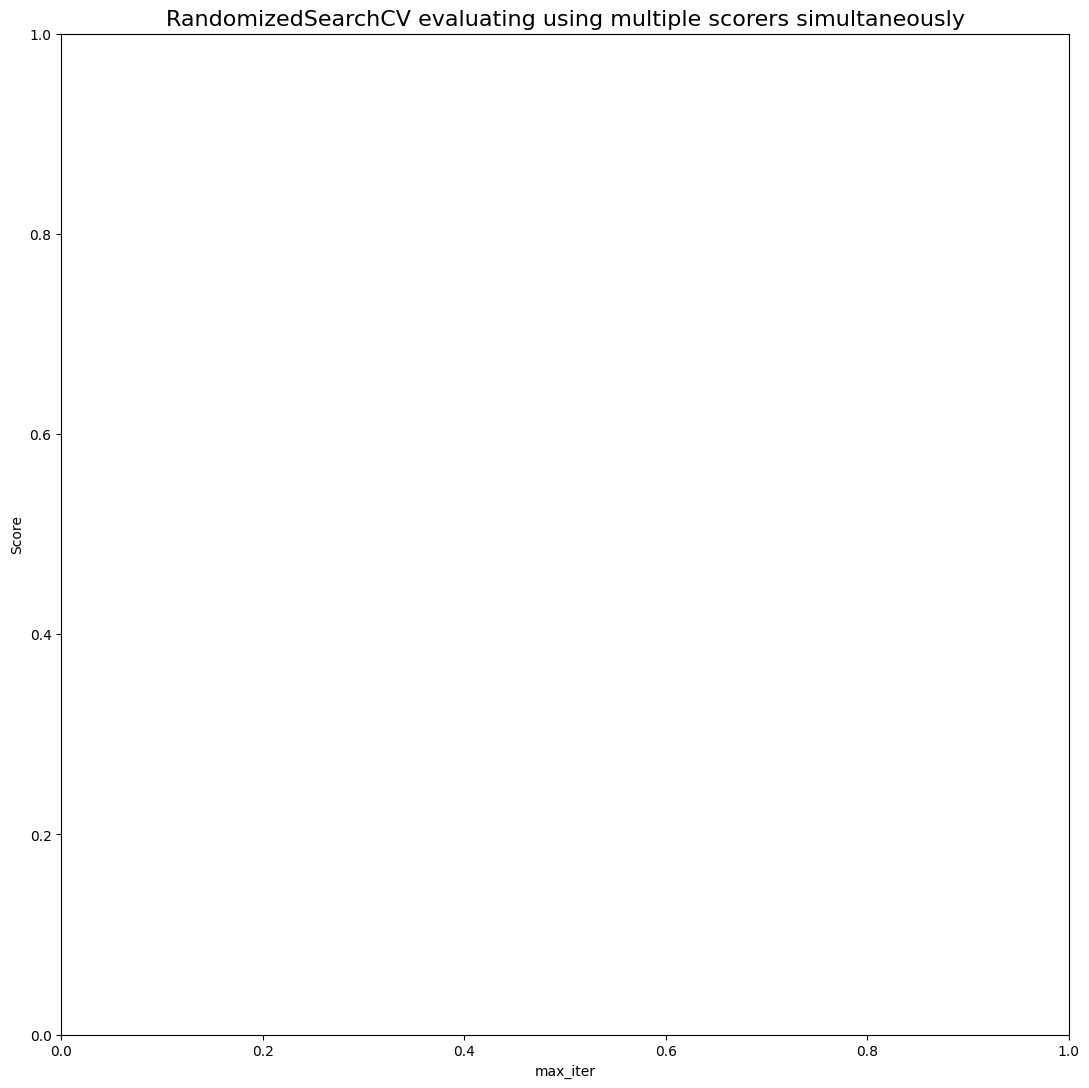

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(13, 13))
plt.title("RandomizedSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_iter")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0.001, 10)
# ax.set_ylim(0.2, 0.8)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(cv_results["max_iter"], dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = cv_results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = cv_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index =rnd_search.best_index_
    best_score = cv_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({
    "learning_rate": cv_results["learning_rate"],
    "mean_train_AUC": cv_results["mean_train_AUC"],
    "mean_test_AUC": cv_results["mean_test_AUC"]
})

fig = px.line(df, x="learning_rate", y=["mean_train_AUC", "mean_test_AUC"], title="RandomizedSearchCV evaluating using multiple scorers simultaneously")
fig.update_layout(
    xaxis_title="learning_rate",
    yaxis_title="Score",
    legend_title="Scorer"
)
fig.show()

In [ ]:
# Displaying a Pipeline with a Preprocessing Step and Regression
from sklearn import set_config
set_config(display="diagram")

rnd_search

#### Best model training and prediction

In [49]:
best_params = rnd_search.best_params_
best_params

{'class_weight': 'balanced',
 'early_stopping': 'auto',
 'learning_rate': 0.007471874727782927,
 'max_depth': 3,
 'max_iter': 189,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 5}

In [50]:
best_hist = HistGradientBoostingClassifier(**best_params)

best_hist.fit(df_train, y_train)

y_pred_train = best_hist.predict(df_train)

# using unseen test data
y_test = y_test.values
y_pred_test = best_hist.predict(df_test)
# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- best_hist test scores appended --')

In [51]:
df = pd.DataFrame(scores)
df

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,HistGradientBoostingClassifier,0.648784,0.624919,0.67375,0.461832,0.481113,0.502075,NaN
1,HistGradientBoostingClassifier,0.648784,NaN,0.68400,0.442997,0.462585,0.483986,0.623078


### Hyperparams Tuning on CatBoostClassifier

#### setup

In [74]:
fold = 0 # reset after HistGradientBoost

df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11)


# student_X = df_test.iloc[0:1].to_json()
# student_y = y_test.iloc[0:1].to_json()
# pprint(student_X)
# pprint(student_y)

logging.info('Starting CatboostClassifier...')


TARGET_NAME = 'target'
Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 238.11it/s]

Finished processing the CSV file.
df.shape = (5000, 7)
features = None

- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...

- FeatureBuilder()...
  -- Creating 'target' column...
  -- Set COLS_CATEGORICAL astype(category)...

- Prepare DFs...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...


In [53]:
all_DFs = [df_full_train, df_train, df_val, df_test]
all_Ys = [y_full_train, y_train, y_val, y_test]
for df in all_DFs:
    print(f'{df.shape = }') 
print()
for y in all_Ys:
    print(f'{y.shape = }')  

df.shape = (4000, 4)
df.shape = (3000, 4)
df.shape = (1000, 4)
df.shape = (1000, 4)

y.shape = (4000,)
y.shape = (3000,)
y.shape = (1000,)
y.shape = (1000,)


In [54]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cat_param_grid = {
    # "loss_function": ["Logloss"],
    "iterations": [10, 100, 200, 500],    # defaults=1000 
    "learning_rate": [0.001, 0.01, 0.1, 1.0],    # defaults=0.1, 1=no shrinkage  
    "min_data_in_leaf": [5, 10, 25, 50], # 
    "max_depth": [2, 6, 8, 12]  # 
}

# Create the model
cat = CatBoostClassifier(
    cat_features=COLS_CATEGORICAL,
    eval_metric='AUC:hints=skip_train~false',
    random_state=42,
    # task_type="GPU",
    # devices='0'
    verbose=0
    )                             


#### train

In [55]:
%%capture output


# Log the output of each step of the tuning process.
logging.info('Starting CatBoostClassifier hyperparam tuning...')

# Perform hyperparameter tuning using RandomizedSearchCV
rnd_search = RandomizedSearchCV(
    estimator=cat, 
    param_distributions=cat_param_grid, 
    cv=kfold,          
    scoring=scoring,       # to replace defaults 'loss'
    refit="AUC",           # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=False,
    n_jobs=-1
)

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    Xf_train = df_full_train.iloc[train_idx]
    Xf_val = df_full_train.iloc[val_idx]

    yf_train = y_full_train.iloc[train_idx].values
    yf_val = y_full_train.iloc[val_idx].values
    
    logging.info(f'-- in rnd_search.fit(); kfold: {fold} --')

    logging.info('Fitting randomized_search model...')
    with open('randomizedcv_tuning.log', 'a') as f:
        with redirect_stdout(f):
            # Train the model on the train data
            rnd_search.fit(Xf_train, yf_train)
    
    fold = fold + 1
    
logging.info('hyperparam with randomized_search fit completed')    

# took about 8mins up to 100 iterations
# took about 20mins up to 500 iterations

In [56]:
# Create a catboost randomized_search object
cat_rnd_search = cat.randomized_search(
    X=df_full_train,
    y=y_full_train,
    param_distributions=cat_param_grid, 
    cv=kfold, 
    n_iter=10,
    calc_cv_statistics=True,
    refit=True,
    shuffle=True,
    stratified=True,
    log_cout=sys.stdout,     
    verbose=False,
    plot=True
)
# took about 4mins

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.675020186
bestIteration = 7


bestTest = 0.6851655253
bestIteration = 14


bestTest = 0.6793227967
bestIteration = 5


bestTest = 0.6750276623
bestIteration = 10


bestTest = 0.6826946081
bestIteration = 98


bestTest = 0.6910157301
bestIteration = 136


bestTest = 0.6803134065
bestIteration = 2


bestTest = 0.6753977392
bestIteration = 6


bestTest = 0.6931016179
bestIteration = 2


bestTest = 0.6823544364
bestIteration = 19

Training on fold [0/5]

bestTest = 0.6787077804
bestIteration = 0

Training on fold [1/5]

bestTest = 0.6932655116
bestIteration = 3

Training on fold [2/5]

bestTest = 0.6473861894
bestIteration = 3

Training on fold [3/5]

bestTest = 0.6566504098
bestIteration = 5

Training on fold [4/5]

bestTest = 0.6500270934
bestIteration = 2



In [57]:
eval_pool = Pool(df_val, y_val, cat_features=COLS_CATEGORICAL)

In [58]:
cat.eval_metrics(
    data=eval_pool,
    metrics=['AUC', 'Accuracy', 'F1', 'Precision', 'Recall'],
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'AUC': [0.6761034985907728,
  0.700317016715859,
  0.69941634703587,
  0.7058208451561081,
  0.7182092120209697,
  0.7169401945826739,
  0.7302363604389754,
  0.7318024325210671,
  0.7318024325210671,
  0.7324416941145158,
  0.735333818126512,
  0.7403409712023346,
  0.7476485154397121,
  0.7551960798292767,
  0.7577032210229135,
  0.7618382216645516,
  0.7681381565501737,
  0.772805479113494,
  0.7788487587868764,
  0.7827841387078835,
  0.7864010760507417,
  0.7912870308318956,
  0.7921473010803284,
  0.7997281355899981,
  0.8072044068650517,
  0.8105147838155125,
  0.8151440833844268,
  0.8177011297582213,
  0.8217981074054534,
  0.824809053274968,
  0.827278171474199,
  0.8309568961829666,
  0.8312610801382136,
  0.8352843882337844,
  0.8368005551357183,
  0.8380885840712171,
  0.8381670064971791,
  0.8389678658168527,
  0.840576713767651,
  0.841503524256294,
  0.8419075185718563,
  0.8441698867390054,
  0.8453390938169858,
  0.8475016516238195,
  0.8492839794865945,
  0.85442658

#### evaluate

In [59]:
cv_results = pd.DataFrame(cat_rnd_search['cv_results'])

In [60]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

auc = np.max(cv_results['test-AUC-mean'])
print(f"AUC on val set: {auc:.3f}")
curve = get_roc_curve(cat, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

AUC on val set: 0.658


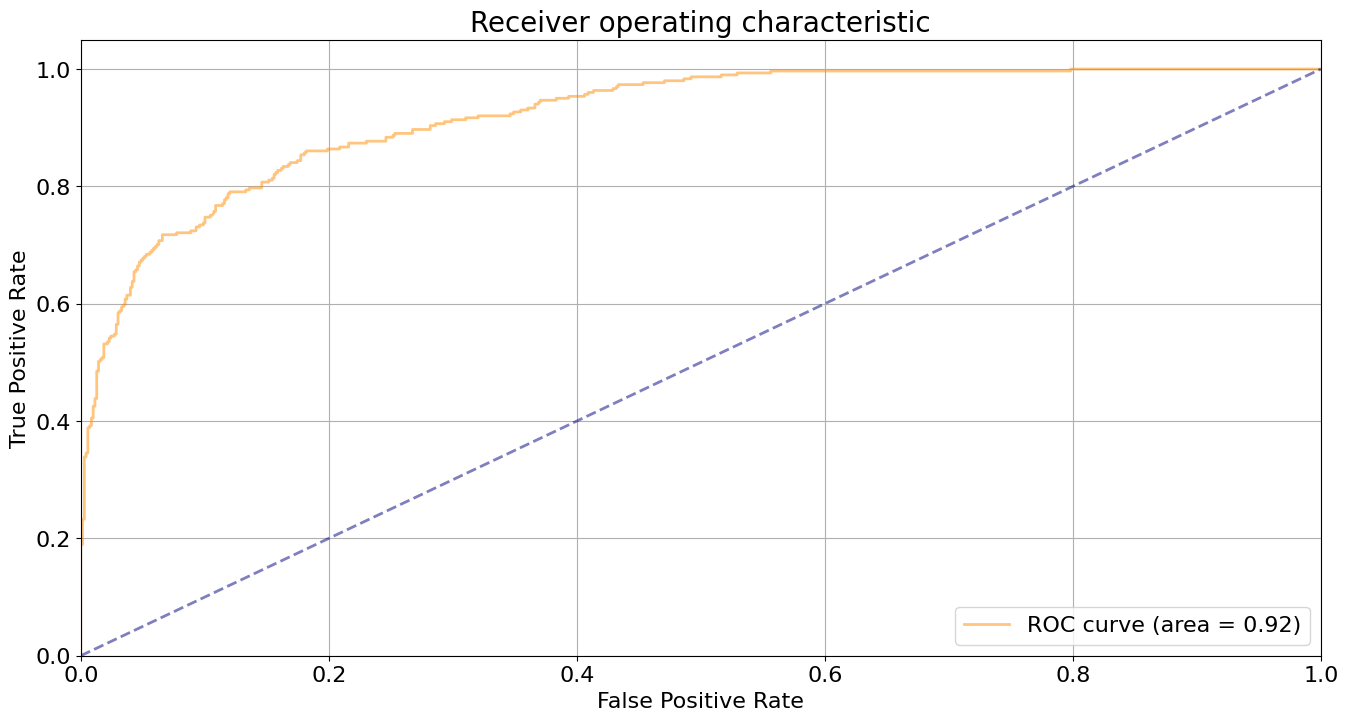

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Best model training and validation prediction

In [62]:
best_params = rnd_search.best_params_

best_cat = CatBoostClassifier(**best_params, verbose=0)
best_cat.fit(
    df_train, 
    y_train, 
    cat_features=COLS_CATEGORICAL
)
y_pred_train = best_cat.predict(df_train)

In [63]:
y_pred = best_cat.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred),
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred),
    "f1_mean": f1_score(y_val, y_pred),
    "recall": recall_score(y_val, y_pred),    
    }
)
logging.info(f'-- best_cat val scores appended --')
# Log the results of the tuning process.
logging.info('The best hyperparameters are: {}'.format(rnd_search.best_params_))

#### Best iteration

## Final Model output

using df_test and the best_params

In [64]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,parental_income,30.861580
1,sat_total_score,27.238493
2,college_gpa,24.835454
3,parental_level_of_education,17.064473


#### predict test

In [65]:
y_pred_proba = best_cat.predict_proba(df_test)
y_pred = best_cat.predict(df_test)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "f1_mean": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),    
    }
)
logging.info(f'-- best_cat test scores appended --')

In [66]:
df = pd.DataFrame(scores)
df

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,HistGradientBoostingClassifier,0.648784,0.624919,0.67375,0.461832,0.481113,0.502075,NaN
1,HistGradientBoostingClassifier,0.648784,NaN,0.68400,0.442997,0.462585,0.483986,0.623078
2,CatBoostClassifier,0.719417,0.588057,0.71500,0.554795,0.362416,0.269103,NaN
3,CatBoostClassifier,0.719417,NaN,0.72900,0.536765,0.350120,0.259786,0.586082


In [69]:
# student = {
#     "sat_total_score": 1400,
#     "parental_level_of_education": "bachelor's degree",
#     "parental_income": 125000,
#     "college_gpa": 3.2
# }

('{"sat_total_score":{"11":0.5388127854},"parental_level_of_education":{"11":"bachelors '
 'degree"},"parental_income":{"11":0.9545175758},"college_gpa":{"11":0.6666666667}}')
'{"11":1}'
